## Polars

Runs through building the data frame - clean, low detail version - more detailed version on github

In splitting function - shuffle=True creates an additional layer of randomness before train_test_split

In [1]:
import polars as pl
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

#SET RANDOM SEED
np.random.seed(42)
random_seed = 42

## Helper functions

In [2]:
def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    # implement here all desired dtypes for tables
    # the following is just an example
    for col in df.columns:
        # last letter of column name will help you determine the type
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))

    return df

def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:  
        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)
    return df

In [3]:
def produce_data_splits(data=None, shuffle=True):
    if shuffle:
        case_ids = data["case_id"].unique().shuffle(seed=random_seed) #shuffle
    else:
        case_ids = data["case_id"].unique()
        print('false')
    case_ids_train, case_ids_test = train_test_split(case_ids, train_size=0.6, random_state=random_seed)
    case_ids_valid, case_ids_test = train_test_split(case_ids_test, train_size=0.5, random_state=random_seed)
    columns_to_select = data.columns[5:]

    def split_data(case_ids) -> pd.DataFrame:
        return (
        data.filter(pl.col("case_id").is_in(case_ids))[["case_id", "WEEK_NUM", "target"]].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))[columns_to_select].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))["target"].to_pandas()
    )
    
    def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
        for col in df.columns:  
            if df[col].dtype.name in ['object', 'string']:
                df[col] = df[col].astype("string").astype('category')
                current_categories = df[col].cat.categories
                new_categories = current_categories.to_list() + ["Unknown"]
                new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True) #  ordered=False?
                df[col] = df[col].astype(new_dtype)
        return df
    
    base_train, X_train, y_train = split_data(case_ids_train)
    base_valid, X_valid, y_valid = split_data(case_ids_valid)
    base_test, X_test, y_test = split_data(case_ids_test)
    for df in [X_train, X_valid, X_test]:
        df = convert_strings(df)

    return base_train, X_train, y_train, base_valid, X_valid, y_valid, base_test, X_test, y_test

In [4]:
def run_training(default_params=True, params_to_use=None): 
    '''Trains the GBM and returns the best model
    If default_params =True -- uses the default, otherwise uses the params that are specified'''

    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)

    if default_params == True:
        params = {
            "boosting_type": "gbdt",
            "objective": "binary",
            "metric": "auc",
            "max_depth": 3,
            "num_leaves": 31,
            "learning_rate": 0.05,
            "feature_fraction": 0.9,
            "bagging_fraction": 0.8,
            "bagging_freq": 5,
            "n_estimators": 2500,
            "random_seed": 42,
            "verbose": -1,
        }
        print(f'Utilizing parameters {params} ')
    else:
        params = params_to_use
        print(f'Utilizing parameters {params}')

    gbm = lgb.train(
        params,
        lgb_train,
        valid_sets=lgb_valid,
        callbacks=[lgb.log_evaluation(100), lgb.early_stopping(100)]
    )
    for base, X in [(base_train, X_train), (base_valid, X_valid), (base_test, X_test)]:
        y_pred = gbm.predict(X, num_iteration=gbm.best_iteration)
        base["score"] = y_pred

    print(f'The AUC score on the train set is: {roc_auc_score(base_train["target"], base_train["score"])}') 
    print(f'The AUC score on the valid set is: {roc_auc_score(base_valid["target"], base_valid["score"])}') 
    print(f'The AUC score on the test set is: {roc_auc_score(base_test["target"], base_test["score"])}')

    return gbm

In [5]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()
    
    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)

    
    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot the original data points
    plt.scatter(x, y, label='Original Data', color='blue')

    # Plot the fitted line
    plt.plot(x, y_hat, label='Fitted Line', color='red')

    # Optionally, plot the average Gini line
    plt.axhline(y=avg_gini, color='green', linestyle='--', label='Average Gini')

    # Add labels and legend
    plt.xlabel('Time')
    plt.ylabel('Gini Coefficient')
    plt.title('Gini Coefficient Over Time')
    plt.legend()

    # Show the plot
    plt.show()
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

# Base table

## Need to add in kaggle data set and data paths

In [6]:
TRAIN_PATH_PARQUET = '../../data/train'

In [7]:
train_basetable = pl.read_parquet( TRAIN_PATH_PARQUET + "/train_base.parquet")

## ApplPrev_1 files - must use join to merge the files - take the max for selected columns

In [8]:
# Read the base parquet file
train_appl1 = pl.read_parquet(TRAIN_PATH_PARQUET+ "/train_applprev_1_0.parquet")
train_appl11 = pl.read_parquet(TRAIN_PATH_PARQUET+ "/train_applprev_1_1.parquet")
train_appl = pl.concat([train_appl1, train_appl11])

#select columns
cols = []
for col in train_appl.columns:
    if col[-1] in ('A', 'M', 'L', 'P'): #from the data description - all columns end in letter - indicating type of data
        cols.append(col)

#aggregate
feature_maxs = train_appl[['case_id'] + cols].group_by('case_id').max()

#merge
train_base_df = train_basetable.join(feature_maxs, how="left", on="case_id")

del train_appl, feature_maxs, train_basetable, train_appl1, train_appl11

In [9]:
train_base_df.shape

(1526659, 37)

## Next file - skipped - not useful?
I didn't use these features in original creation of data frame because they did not appear informative

In [10]:
train_appl2 = pl.read_parquet(TRAIN_PATH_PARQUET+ "/train_applprev_2.parquet") 
train_appl2.head()

case_id,cacccardblochreas_147M,conts_type_509L,credacc_cards_status_52L,num_group1,num_group2
i64,str,str,str,i64,i64
2,null,"""EMPLOYMENT_PHO…",null,1,1
2,null,"""EMPLOYMENT_PHO…",null,0,1
2,null,"""PRIMARY_MOBILE…",null,0,0
2,null,"""PRIMARY_MOBILE…",null,1,0
3,null,"""PRIMARY_MOBILE…",null,0,1


In [11]:
del train_appl2

## Credit_Bureau_A Files

must alter the process to work with polars

In [12]:
train_cba1 = None
for i in range(4):
    if i == 0:
        file_path = TRAIN_PATH_PARQUET + f'/train_credit_bureau_a_1_{i}.parquet'
        train_cba1 = pl.read_parquet(file_path)
        cols = ['case_id','num_group1']
        for col in train_cba1.columns:
            if col[-1] in ('A', 'M', 'L', 'P'): #from the data description - all columns end in letter - indicating type of data
                cols.append(col)
        train_cba1 = train_cba1[cols]
    else:
        file_path = TRAIN_PATH_PARQUET + f'/train_credit_bureau_a_1_{i}.parquet'
        df = pl.read_parquet(file_path)
        df = df[cols]
        train_cba1 = train_cba1.vstack(df)

## Filter to num_group1=0 - can proceed in single step - will use explicit multiple steps for ease of reading code

In [13]:
numgroup0 = train_cba1.filter(pl.col('num_group1') ==0)
del train_cba1
numgroup0 = numgroup0.drop('num_group1')
#aggregate
feature_maxs = numgroup0.group_by('case_id').max() # this isn't required because I filtered to num_group1==0, but perfrom for consistency
#merge
train_base_df = train_base_df.join(feature_maxs, on='case_id', how='left')
del feature_maxs, numgroup0, df

In [14]:
train_base_df.shape

(1526659, 94)

In [15]:
train_base_df.head()

case_id,date_decision,MONTH,WEEK_NUM,target,actualdpd_943P,annuity_853A,byoccupationinc_3656910L,cancelreason_3545846M,childnum_21L,credacc_actualbalance_314A,credacc_credlmt_575A,credacc_maxhisbal_375A,credacc_minhisbal_90A,credacc_status_367L,credacc_transactions_402L,credamount_590A,credtype_587L,currdebt_94A,district_544M,downpmt_134A,education_1138M,familystate_726L,inittransactioncode_279L,isbidproduct_390L,isdebitcard_527L,mainoccupationinc_437A,maxdpdtolerance_577P,outstandingdebt_522A,pmtnum_8L,postype_4733339M,profession_152M,rejectreason_755M,rejectreasonclient_4145042M,revolvingaccount_394A,status_219L,tenor_203L,…,monthlyinstlamount_674A,nominalrate_281L,nominalrate_498L,numberofcontrsvalue_258L,numberofcontrsvalue_358L,numberofinstls_229L,numberofinstls_320L,numberofoutstandinstls_520L,numberofoutstandinstls_59L,numberofoverdueinstlmax_1039L,numberofoverdueinstlmax_1151L,numberofoverdueinstls_725L,numberofoverdueinstls_834L,outstandingamount_354A,outstandingamount_362A,overdueamount_31A,overdueamount_659A,overdueamountmax2_14A,overdueamountmax2_398A,overdueamountmax_155A,overdueamountmax_35A,periodicityofpmts_1102L,periodicityofpmts_837L,prolongationcount_1120L,prolongationcount_599L,purposeofcred_426M,purposeofcred_874M,residualamount_488A,residualamount_856A,subjectrole_182M,subjectrole_93M,totalamount_6A,totalamount_996A,totaldebtoverduevalue_178A,totaldebtoverduevalue_718A,totaloutstanddebtvalue_39A,totaloutstanddebtvalue_668A
i64,str,i64,i64,i64,f64,f64,f64,str,f64,f64,f64,f64,f64,str,f64,f64,str,f64,str,f64,str,str,str,bool,bool,f64,f64,f64,f64,str,str,str,str,f64,str,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64,str,str,f64,f64,f64,f64,f64,f64
0,"""2019-01-03""",201901,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
1,"""2019-01-03""",201901,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2,"""2019-01-04""",201901,0,0,0.0,1682.4,null,"""a55475b1""",0.0,null,0.0,null,null,null,null,16000.0,"""CAL""",null,"""P136_108_173""",0.0,"""P97_36_170""","""SINGLE""","""CASH""",false,null,8200.0,null,null,24.0,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,"""D""",24.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
3,"""2019-01-03""",201901,0,0,0.0,6140.0,null,"""P94_109_143""",null,null,0.0,null,null,null,null,59999.8,"""CAL""",null,"""P131_33_167""",0.0,"""P97_36_170""","""MARRIED""","""CASH""",false,null,11000.0,null,null,12.0,"""a55475b1""","""a55475b1""","""P94_109_143""","""a55475b1""",null,"""D""",12.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
4,"""2019-01-04""",201901,0,1,0.0,2556.6,null,"""P24_27_36""",null,null,0.0,null,null,null,null,40000.0,"""CAL""",null,"""P194_82_174""",0.0,"""a55475b1""",null,"""CASH""",false,null,16000.0,null,null,24.0,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,"""T""",24.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


## repeat this process for all files in credit_bureau_a_2 and vstack

In [16]:
#redo this process to match polars
for i in range(11):
    if i ==0:
        file_path = TRAIN_PATH_PARQUET + f'/train_credit_bureau_a_2_{i}.parquet'
        df = pl.read_parquet(file_path)

        #create the base data frame and then vstack all others
        train_cba2 = df.group_by(['case_id','num_group1']).max().group_by('case_id').max().rename({'num_group1':'num_group1_credit_bureau_a_2'})
        
        #delete df
        del df
    else:
        file_path = TRAIN_PATH_PARQUET + f'/train_credit_bureau_a_2_{i}.parquet'
        df = pl.read_parquet(file_path)
        df = df.group_by(['case_id','num_group1']).max().group_by('case_id').max().rename({'num_group1':'num_group1_credit_bureau_a_2'})

        train_cba2 = train_cba2.vstack(df)
    
        #delete df
        del df

train_cba2.shape

(1385288, 19)

In [17]:
#merge into base
train_base_df = train_base_df.join(train_cba2, on='case_id', how='left')

In [18]:
train_base_df.shape

(1526659, 112)

In [19]:
 del train_cba2

## Add in static

In [20]:
train_static = pl.concat(
    [
        pl.read_parquet(TRAIN_PATH_PARQUET + "/train_static_0_0.parquet").pipe(set_table_dtypes),
        pl.read_parquet(TRAIN_PATH_PARQUET + "/train_static_0_1.parquet").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
train_static_cb = pl.read_parquet(TRAIN_PATH_PARQUET + "/train_static_cb_0.parquet").pipe(set_table_dtypes)
train_credit_bureau_b_2 = pl.read_parquet(TRAIN_PATH_PARQUET + "/train_credit_bureau_b_2.parquet").pipe(set_table_dtypes) 

In [21]:
# We will process in this examples only A-type and M-type columns, so we need to select them.
selected_static_cols = []
for col in train_static.columns:
    if col[-1] in ("A", "M", "L", "P"):
        selected_static_cols.append(col)

selected_static_cb_cols = []
for col in train_static_cb.columns:
    if col[-1] in ("A", "M", "L", "P"):
        selected_static_cb_cols.append(col)


train_base_df = train_base_df.join(
    train_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    train_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
)

In [22]:
train_base_df.shape

(1526659, 305)

## Continue extension

In [23]:
# Read the parquet files
train_cbb1 = pl.read_parquet(TRAIN_PATH_PARQUET + "/train_credit_bureau_b_1.parquet")
train_cbb2 = pl.read_parquet(TRAIN_PATH_PARQUET + "/train_credit_bureau_b_2.parquet")

cols = []
for col in train_cbb1.columns:
    if col[-1] in ('A', 'M', 'L', 'P'): #from the data description - all columns end in letter - indicating type of data
        cols.append(col)
train_cbb1_mod = train_cbb1[['case_id'] + cols].group_by('case_id').max()


train_cbb2_mod = train_cbb2.group_by(['case_id','num_group1']).max().group_by('case_id').max().rename({'num_group1':'num_group1_cbb2', 'num_group2':'num_group2_cbb2'})

train_base_df = train_base_df.join(train_cbb1_mod, on='case_id', how='left')
train_base_df = train_base_df.join(train_cbb2_mod, on='case_id', how='left')
del train_cbb1, train_cbb1_mod, train_cbb2, train_cbb2_mod

## drop the date column to be consistent with pandas data frames

pmts_date_1107D

In [24]:
train_base_df = train_base_df.drop('pmts_date_1107D')
train_base_df.shape

(1526659, 345)

## Extend with more files

In [25]:
# Read the parquet files
train_debit1 = pl.read_parquet(TRAIN_PATH_PARQUET + "/train_debitcard_1.parquet")
train_deposit1 = pl.read_parquet(TRAIN_PATH_PARQUET + "/train_deposit_1.parquet")

In [26]:
# columns of interest
cols = []
for col in train_debit1.columns:
    if col[-1] in ('A', 'M', 'L', 'P'): #from the data description - all columns end in letter - indicating type of data
        cols.append(col)
train_debit1_mod = train_debit1[['case_id','num_group1'] + cols].group_by(['case_id','num_group1']).max().group_by('case_id').max()\
                    .rename({'num_group1':'num_group1_train_debit1'})
train_base_df = train_base_df.join(train_debit1_mod, on='case_id', how='left')
del train_debit1, train_debit1_mod

In [27]:
cols = []
for col in train_deposit1.columns:
    if col[-1] in ('A', 'M', 'L', 'P'): #from the data description - all columns end in letter - indicating type of data
        cols.append(col)
grouped_df = train_deposit1[['case_id','num_group1'] + cols].group_by(['case_id', 'num_group1']).max()

train_deposit1_mod = grouped_df.group_by('case_id').max().rename({'num_group1': 'num_group1_train_deposit1'})

train_base_df = train_base_df.join(train_deposit1_mod, on='case_id', how='left')

del train_deposit1, train_deposit1_mod

## Continue extension

In [28]:
# Read the parquet files
train_other1 = pl.read_parquet(TRAIN_PATH_PARQUET + "/train_other_1.parquet")
train_person1 = pl.read_parquet(TRAIN_PATH_PARQUET + "/train_person_1.parquet")
train_person2 = pl.read_parquet(TRAIN_PATH_PARQUET + "/train_person_2.parquet")

In [29]:
#will drop for now - not sure why it is included here
train_other1_mod = train_other1.drop('num_group1').group_by('case_id').max()
train_base_df = train_base_df.join(train_other1_mod, on='case_id', how='left')

In [30]:
del train_other1_mod, train_other1

## Next file

Num_group1 == 0, means the actual person taking out the loan (not reference)

In [31]:
# matches the case_id - one to one relationship --> essentially is ignoring references
train_person1_numgroup0 = train_person1.filter(pl.col('num_group1') == 0)
train_base_df = train_base_df.join(train_person1_numgroup0, on='case_id', how='left')

In [32]:
del train_person1_numgroup0, train_person1

In [33]:
train_base_df.shape

(1526659, 392)

## Train Person 2

Complex num_group information

I believe num_group1==0, num_group2==0 is the actual loan taker

In [34]:
train_person2_num00 = train_person2.filter((pl.col('num_group1') == 0) & (pl.col('num_group2') == 0))

#now do not need num_group columns
train_person2_num00 = train_person2_num00.drop(['num_group1','num_group2'])

In [35]:
train_base_df = train_base_df.join(train_person2_num00, on='case_id', how='left')

In [36]:
del train_person2_num00

## Final extensions

In [37]:
# Read the parquet files
train_taxa = pl.read_parquet(TRAIN_PATH_PARQUET + "/train_tax_registry_a_1.parquet")
train_taxb = pl.read_parquet(TRAIN_PATH_PARQUET + "/train_tax_registry_b_1.parquet")
train_taxc = pl.read_parquet(TRAIN_PATH_PARQUET + "/train_tax_registry_c_1.parquet")

In [38]:
train_taxa_mod = train_taxa.group_by('case_id').max().rename({'num_group1':'num_group1_train_taxa'})
train_taxb_mod = train_taxb.group_by('case_id').max().rename({'num_group1':'num_group1_train_taxb'})
train_taxc_mod = train_taxc.group_by('case_id').max().rename({'num_group1':'num_group1_train_taxc'})

In [39]:
train_base_df = train_base_df.join(train_taxa_mod, on='case_id', how='left')\
                    .join(train_taxb_mod, on='case_id', how='left')\
                    .join(train_taxc_mod, on='case_id', how='left')

In [40]:
train_base_df.shape

(1526659, 412)

## Save data

In [42]:
# save data - polars uses write_parquet
train_base_df.write_parquet('model_412.parquet')

In [43]:
base_train, X_train, y_train, base_valid, X_valid, y_valid, base_test, X_test, y_test = produce_data_splits(data=train_base_df, shuffle=True)

## Issue with the one column being incorrect data type

In [44]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 915995 entries, 0 to 915994
Columns: 407 entries, actualdpd_943P to processingdate_168D
dtypes: bool(1), category(114), float64(291), int64(1)
memory usage: 2.1 GB


In [45]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305332 entries, 0 to 305331
Columns: 407 entries, actualdpd_943P to processingdate_168D
dtypes: bool(2), category(113), float64(291), int64(1)
memory usage: 726.2 MB


In [46]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305332 entries, 0 to 305331
Columns: 407 entries, actualdpd_943P to processingdate_168D
dtypes: bool(1), category(114), float64(291), int64(1)
memory usage: 726.2 MB


In [47]:
bool_columns_v = X_valid.select_dtypes(include='bool').columns.tolist()
bool_columns_v

['isbidproduct_1095L', 'safeguarantyflag_411L']

In [48]:
bool_columns_tr = X_train.select_dtypes(include='bool').columns.tolist()
bool_columns_tr

['isbidproduct_1095L']

In [49]:
bool_columns_te = X_test.select_dtypes(include='bool').columns.tolist()
bool_columns_te

['isbidproduct_1095L']

In [50]:
X_valid[bool_columns_v] = X_valid[bool_columns_v].astype('category')
X_test[bool_columns_te] = X_test[bool_columns_te].astype('category')
X_train[bool_columns_tr] = X_train[bool_columns_tr].astype('category')

In [73]:
gbm = run_training(default_params=True, params_to_use=None)

Utilizing parameters {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'max_depth': 3, 'num_leaves': 31, 'learning_rate': 0.05, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'n_estimators': 2500, 'random_seed': 42, 'verbose': -1} 


c:\Users\nick\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\nick\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:2054: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.81965
[200]	valid_0's auc: 0.832639
[300]	valid_0's auc: 0.837546
[400]	valid_0's auc: 0.840622
[500]	valid_0's auc: 0.842727
[600]	valid_0's auc: 0.844316
[700]	valid_0's auc: 0.845565
[800]	valid_0's auc: 0.846603
[900]	valid_0's auc: 0.847438
[1000]	valid_0's auc: 0.848488
[1100]	valid_0's auc: 0.849139
[1200]	valid_0's auc: 0.84967
[1300]	valid_0's auc: 0.85
[1400]	valid_0's auc: 0.85046
[1500]	valid_0's auc: 0.850667
[1600]	valid_0's auc: 0.850978
[1700]	valid_0's auc: 0.851204
[1800]	valid_0's auc: 0.851397
[1900]	valid_0's auc: 0.851582
[2000]	valid_0's auc: 0.851605
[2100]	valid_0's auc: 0.851917
[2200]	valid_0's auc: 0.85209
[2300]	valid_0's auc: 0.852134
[2400]	valid_0's auc: 0.852351
[2500]	valid_0's auc: 0.852383
Did not meet early stopping. Best iteration is:
[2493]	valid_0's auc: 0.852392
The AUC score on the train set is: 0.8816608165060869
The AUC score on the valid set is: 0.8523921632

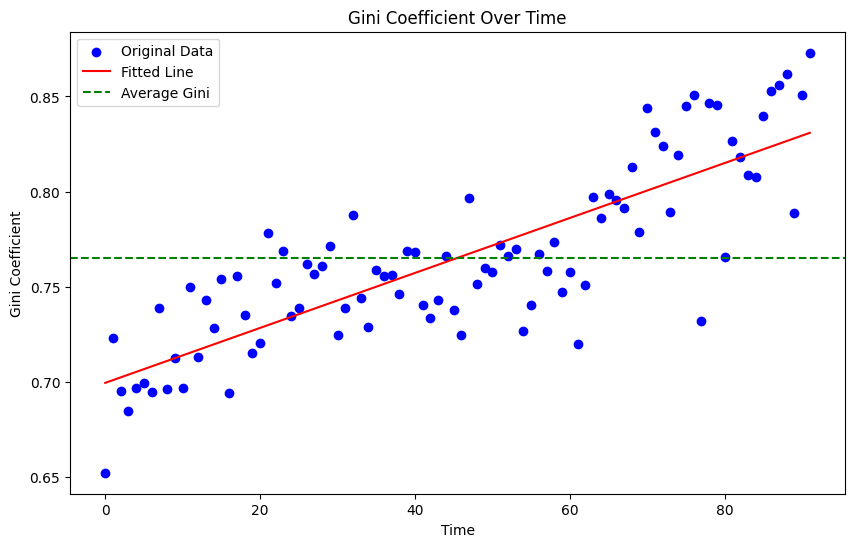

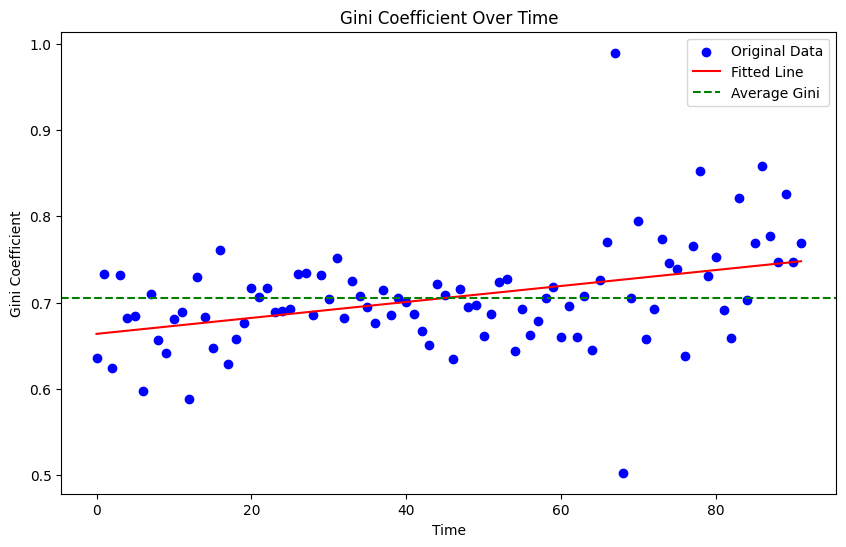

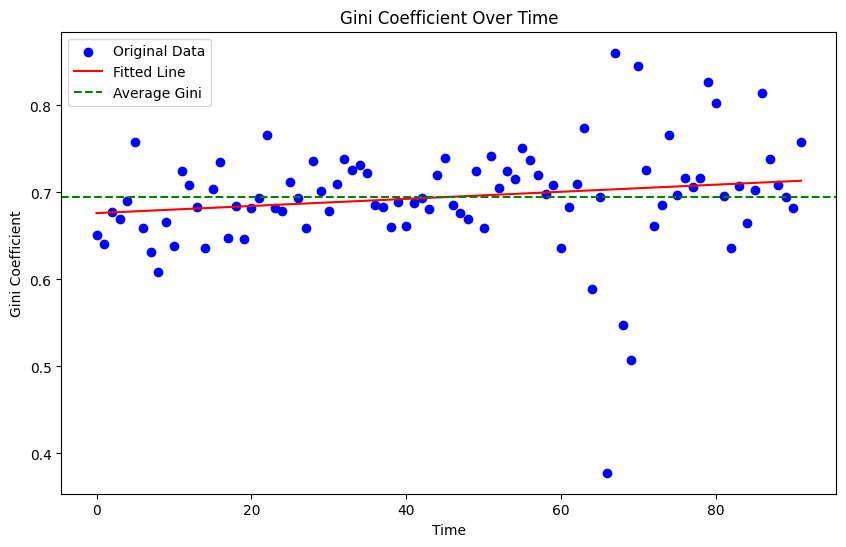

The stability score on the train set is: 0.752067685426335
The stability score on the valid set is: 0.6777848077788746
The stability score on the test set is: 0.6639868488107652


In [74]:
stability_score_train = gini_stability(base_train)
stability_score_valid = gini_stability(base_valid)
stability_score_test = gini_stability(base_test)

print(f'The stability score on the train set is: {stability_score_train}') 
print(f'The stability score on the valid set is: {stability_score_valid}') 
print(f'The stability score on the test set is: {stability_score_test}') 

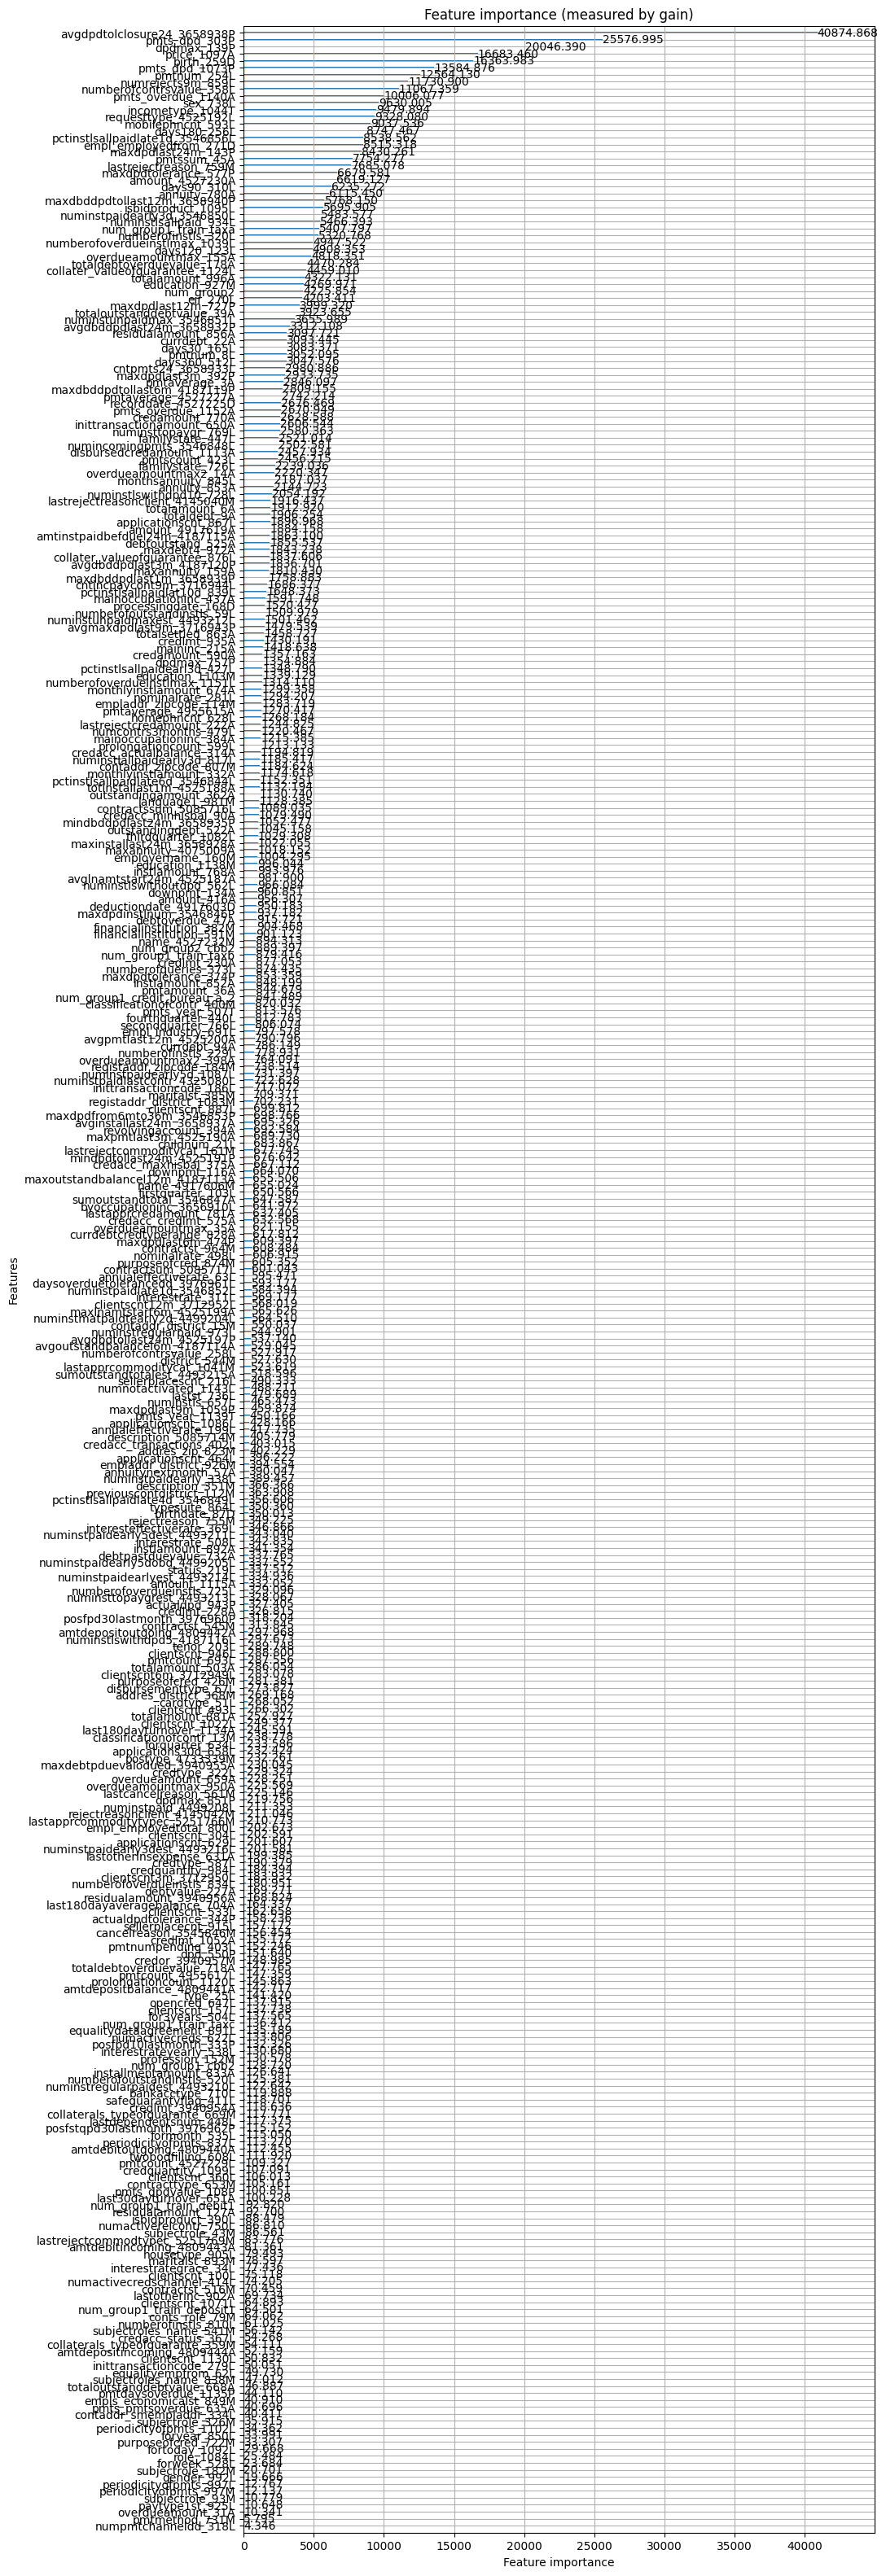

In [75]:
# Plot feature importance measured by gain
lgb.plot_importance(gbm, importance_type='gain', figsize=(10, 40), title='Feature importance (measured by gain)')
plt.show()

In [56]:
longer_params = {
            "boosting_type": "gbdt",
            "objective": "binary",
            "metric": "auc",
            "max_depth": 3,
            "num_leaves": 31,
            "learning_rate": 0.05,
            "feature_fraction": 0.9,
            "bagging_fraction": 0.8,
            "bagging_freq": 5,
            "n_estimators": 10000,
            "random_seed": 42,
            "verbose": -1,
        }

In [57]:
gbm = run_training(default_params=False, params_to_use=longer_params)

Utilizing parameters {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'max_depth': 3, 'num_leaves': 31, 'learning_rate': 0.05, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'n_estimators': 10000, 'random_seed': 42, 'verbose': -1}


c:\Users\nick\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\nick\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:2054: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.81965
[200]	valid_0's auc: 0.832639
[300]	valid_0's auc: 0.837546
[400]	valid_0's auc: 0.840622
[500]	valid_0's auc: 0.842727
[600]	valid_0's auc: 0.844316
[700]	valid_0's auc: 0.845565
[800]	valid_0's auc: 0.846603
[900]	valid_0's auc: 0.847438
[1000]	valid_0's auc: 0.848488
[1100]	valid_0's auc: 0.849139
[1200]	valid_0's auc: 0.84967
[1300]	valid_0's auc: 0.85
[1400]	valid_0's auc: 0.85046
[1500]	valid_0's auc: 0.850667
[1600]	valid_0's auc: 0.850978
[1700]	valid_0's auc: 0.851204
[1800]	valid_0's auc: 0.851397
[1900]	valid_0's auc: 0.851582
[2000]	valid_0's auc: 0.851605
[2100]	valid_0's auc: 0.851917
[2200]	valid_0's auc: 0.85209
[2300]	valid_0's auc: 0.852134
[2400]	valid_0's auc: 0.852351
[2500]	valid_0's auc: 0.852383
[2600]	valid_0's auc: 0.852413
[2700]	valid_0's auc: 0.852518
[2800]	valid_0's auc: 0.852655
[2900]	valid_0's auc: 0.852787
[3000]	valid_0's auc: 0.85285
[3100]	valid_0's auc: 0.85

In [59]:
gbm.save_model('model_412.bin')

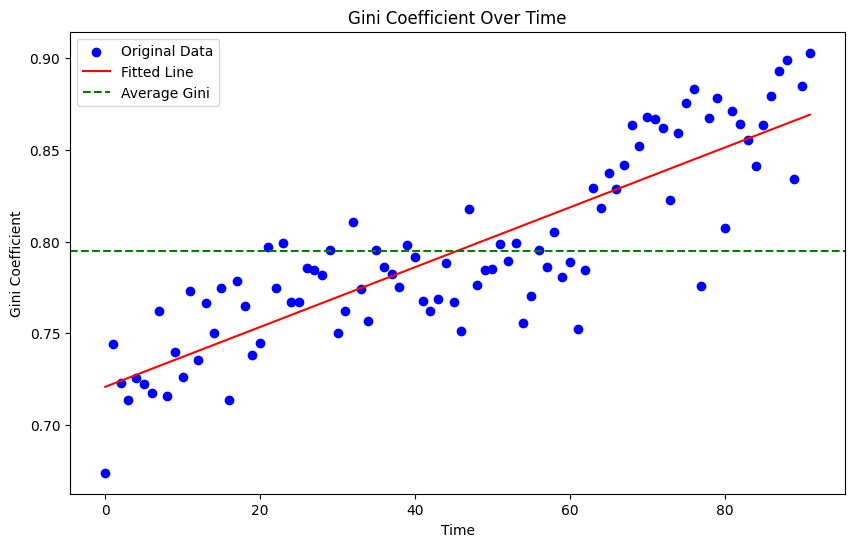

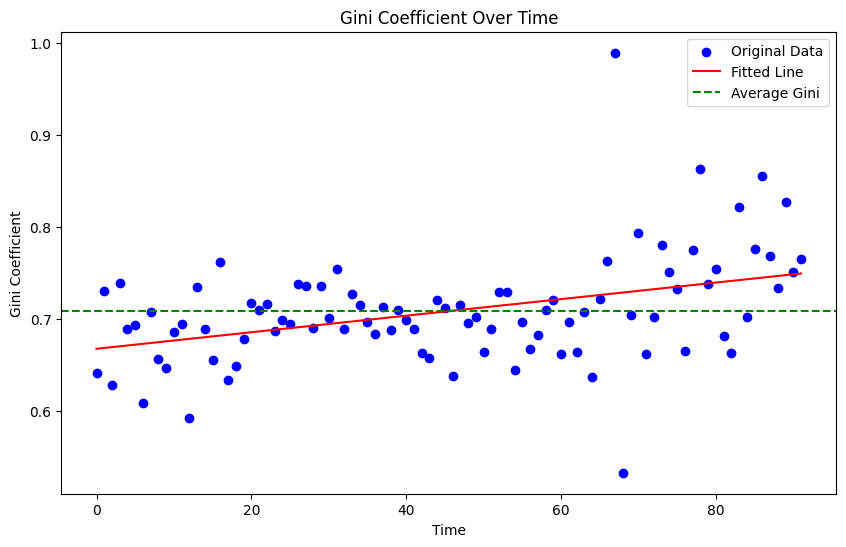

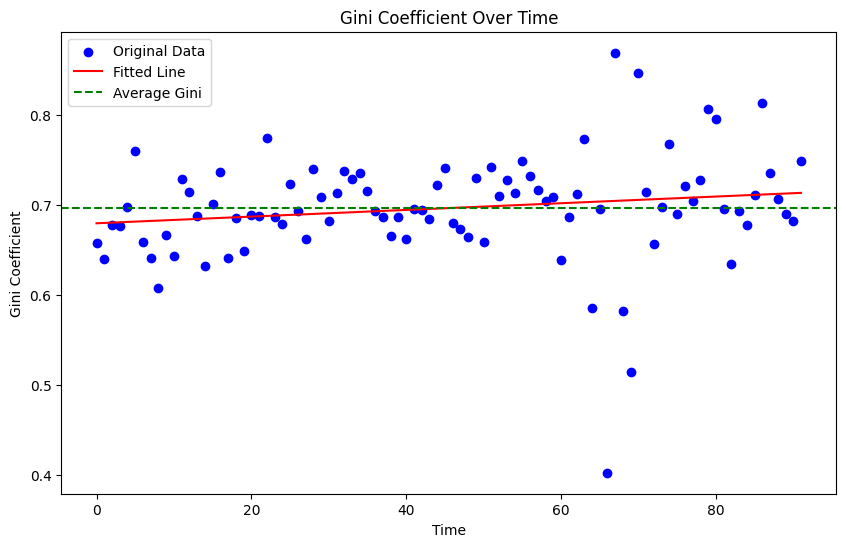

The stability score on the train set is: 0.7823217036288027
The stability score on the valid set is: 0.6810760365623141
The stability score on the test set is: 0.6667783489642845


In [60]:
stability_score_train = gini_stability(base_train)
stability_score_valid = gini_stability(base_valid)
stability_score_test = gini_stability(base_test)

print(f'The stability score on the train set is: {stability_score_train}') 
print(f'The stability score on the valid set is: {stability_score_valid}') 
print(f'The stability score on the test set is: {stability_score_test}') 

## Use custom gini stability metric

In [61]:
def gini_weighted_stability_metric(preds, train_data, base=base_valid):
    base['score'] = preds

    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()

    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)

    w_fallingrate = 88.0
    w_resstd = -.5

    weighted_gini = avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

    return 'weighted gini stability', weighted_gini, True  # The third parameter indicates whether higher values are better

## Alter training to use weighted stability metric for evaluation

In [63]:
def run_training(default_params=True, params_to_use=None):
    '''Trains the GBM and returns the best model
    If default_params =True -- uses the default, otherwise uses the params that are specified'''

    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)

    if default_params == True:
        params = {
            "boosting_type": "gbdt",
            "objective": "binary",
            "metric": "custom",
            "max_depth": 3,
            "num_leaves": 31,
            "learning_rate": 0.05,
            "feature_fraction": 0.9,
            "bagging_fraction": 0.8,
            "bagging_freq": 5,
            "n_estimators": 2500,
            "random_seed": 42,
            "verbose": -1,
        }
        print(f'Utilizing parameters {params} ')
    else:
        params = params_to_use
        print(f'Utilizing parameters {params}')

    # Update the lgb.train function with custom metric
    gbm = lgb.train(
        params,
        lgb_train,
        valid_sets=lgb_valid,
        callbacks=[lgb.log_evaluation(100), lgb.early_stopping(100)],
        feval=gini_weighted_stability_metric
    )

    for base, X in [(base_train, X_train), (base_valid, X_valid), (base_test, X_test)]:
        y_pred = gbm.predict(X, num_iteration=gbm.best_iteration)
        base["score"] = y_pred

    print(f'The AUC score on the train set is: {roc_auc_score(base_train["target"], base_train["score"])}')
    print(f'The AUC score on the valid set is: {roc_auc_score(base_valid["target"], base_valid["score"])}')
    print(f'The AUC score on the test set is: {roc_auc_score(base_test["target"], base_test["score"])}')

    return gbm

In [64]:
gbm = run_training(default_params=True, params_to_use=longer_params)

Utilizing parameters {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'custom', 'max_depth': 3, 'num_leaves': 31, 'learning_rate': 0.05, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'n_estimators': 2500, 'random_seed': 42, 'verbose': -1} 


c:\Users\nick\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\nick\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:2054: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	valid_0's weighted gini stability: 0.605783
[200]	valid_0's weighted gini stability: 0.635385
[300]	valid_0's weighted gini stability: 0.645311
[400]	valid_0's weighted gini stability: 0.65245
[500]	valid_0's weighted gini stability: 0.657259
[600]	valid_0's weighted gini stability: 0.661293
[700]	valid_0's weighted gini stability: 0.665275
[800]	valid_0's weighted gini stability: 0.666098
[900]	valid_0's weighted gini stability: 0.667623
[1000]	valid_0's weighted gini stability: 0.669472
[1100]	valid_0's weighted gini stability: 0.671087
[1200]	valid_0's weighted gini stability: 0.672193
[1300]	valid_0's weighted gini stability: 0.672896
[1400]	valid_0's weighted gini stability: 0.673842
[1500]	valid_0's weighted gini stability: 0.67492
[1600]	valid_0's weighted gini stability: 0.675155
[1700]	valid_0's weighted gini stability: 0.676054
[1800]	valid_0's weighted gini stability: 0.675966
[1900]	valid_0's weighted gini 

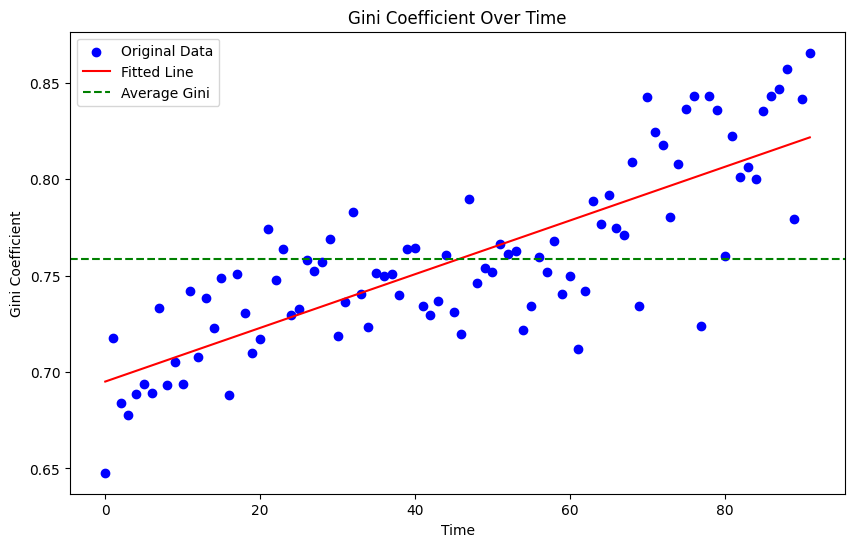

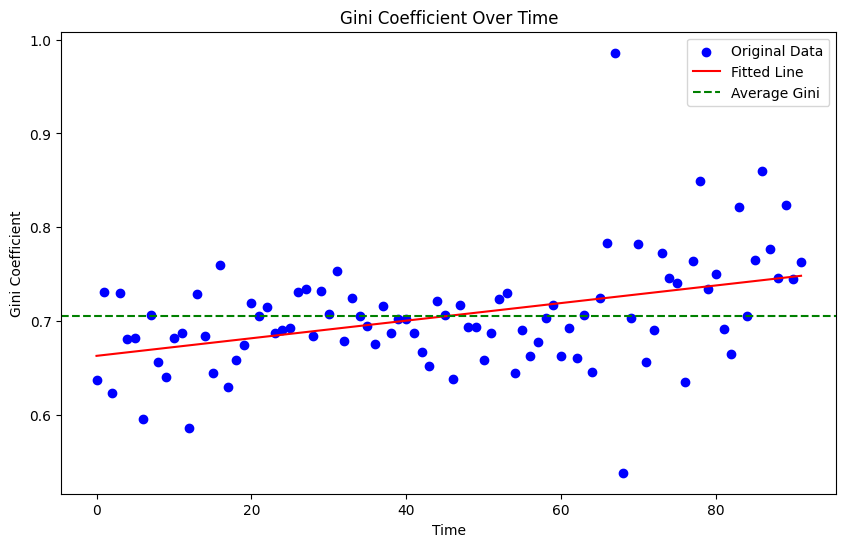

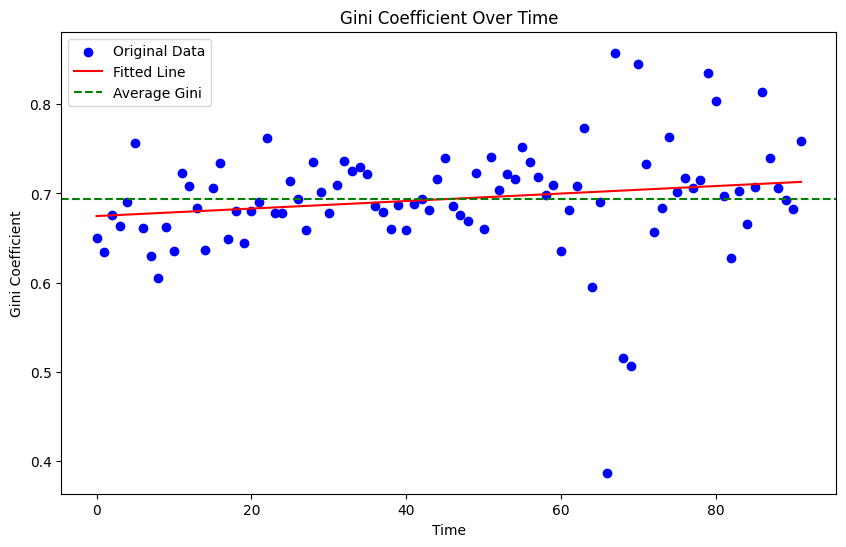

The stability score on the train set is: 0.7447749920815028
The stability score on the valid set is: 0.6784792194964308
The stability score on the test set is: 0.6626424686787258


In [65]:
stability_score_train = gini_stability(base_train)
stability_score_valid = gini_stability(base_valid)
stability_score_test = gini_stability(base_test)

print(f'The stability score on the train set is: {stability_score_train}') 
print(f'The stability score on the valid set is: {stability_score_valid}') 
print(f'The stability score on the test set is: {stability_score_test}') 